In [ ]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [2]:
# Check if TensorFlow is using the Metal plugin (I'm using a Macbook Air with a built in 16-core Neural Engin, want to make sure I'm using that to ensure faster runtime)
print("TensorFlow is using Metal:", tf.config.list_physical_devices('GPU'))

TensorFlow is using Metal: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Preprocessing

In [ ]:
# ---- Global Variables and Methods----
IMAGE_FOLDER = "images/"
SAL_MAP_FOLDER = "saliency_maps/"
CSV_FILE = 'image_types.csv'
IMG_SIZE = (224, 224, 3)

def normalize(heatmap):
    '''
    Normalize heatmap values in the [0,1] range.
    This method is from 'sal_imp_utilities.py' written by the UEyes team.
    '''

    # Apply mimaxscaler algorithm (https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization))
    heatmap = (heatmap - K.min(heatmap)) / (K.epsilon() + K.max(heatmap) - K.min(heatmap))

    # Sum normalization
    heatmap /= (K.epsilon() + K.sum(heatmap))
    
    return heatmap

In [ ]:
# ---- Data Generator ----
class DataGenerator(tf.keras.utils.Sequence):
    '''
    A custom data loader for the UI images and saliency maps, inheriting from tf.keras.utils.Sequence.
    For instance, can be used with the following methods:
        model.fit(train_data_gen, validation_data=val_data_gen, ...)
        predictions = model.predict(data_gen)
        loss, mae = model.evaluate(data_gen)
    '''
    def __init__(self, image_folder, sal_map_folder, filenames, batch_size=1, shuffle=True, sample_size=None):
        '''
        Constructor:
            image_folder (str): Path to the folder containing input images.
            sal_map_folder (str): Path to the folder containing saliency maps.
            filenames (list): List of filenames to include in this generator.
            batch_size (int): Number of samples per batch.
            shuffle (bool): Whether to shuffle the data at the end of each epoch.
            sample_size (int): Number of samples to use (for debugging).
        '''
        self.image_folder = image_folder # string, path to the folder containing input images
        self.sal_map_folder = sal_map_folder # string, path to the folder containing saliency maps
        self.batch_size = batch_size # int, number of samples per batch
        self.filenames = filenames # list of filenames (shared between the input images and their corresponding saliency maps) to convert to data
        self.sample_size = sample_size
        self.shuffle = shuffle # boolean, if using random shuffle each epoch

        # Limit the dataset to a (smaller) sample_size if specified
        if self.sample_size and self.sample_size<len(self.filenames):
            self.filenames = self.filenames[:self.sample_size]

        self.on_epoch_end() # random shuffle

    def on_epoch_end(self): # if using random shuffle each epoch
        '''If shuffle=True, shuffles the list of filenames to randomize the order of data for the next epoch (automatically called by Keras)'''
        if self.shuffle:
            np.random.shuffle(self.filenames)

    def __len__(self):
        '''Returns the number of batches per epoch'''
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        '''
        Generates one batch of data given the index of the batch (automatically called by Keras)
        Returns tuple (X, Y), both normalized to [0,1]
        X: batch of input images of shape (batch_size, height, width, channels)
        Y: batch of corresponding saliency maps of shape (batch_size, height, width, 1)
        
        Can be called using the [] indexing operator
        '''
        # select a subset of filenames for the current batch
        batch_files = self.filenames[index * self.batch_size:(index + 1) * self.batch_size]

        # load and preprocess the images and saliency maps for the specified batch
        return self.__data_generation(batch_files)
    
    def __data_generation(self, batch_files):
        '''
        Load and preprocess the images and saliency maps.
        Returns tuple (X, Y), both normalized to [0,1]
        X: batch of input images of shape (batch_size, height, width, channels)
        Y: batch of corresponding saliency maps of shape (batch_size, height, width, 1)
        '''
        X, Y = [], []
        for file in batch_files:
            # UI image
            img_path = os.path.join(self.image_folder, file)
            img = load_img(img_path, target_size=IMG_SIZE[:2]) # load and resize image to IMG_SIZE
            img = img_to_array(img) / 255.0 # convert images to arrays and normalize them to [0,1]
            
            # corresponding saliency map (grayscale)
            sal_path = os.path.join(self.sal_map_folder, file)
            sal_img = load_img(sal_path, target_size=IMG_SIZE[:2], color_mode="grayscale") # load and resize image to IMG_SIZE
            sal_img = img_to_array(sal_img) / 255.0 # convert images to arrays and normalize them to [0,1], use normalize()????
            
            X.append(img)
            Y.append(sal_img)

        return np.array(X), np.array(Y) # convert from list to np.arrays

In [ ]:
# ---- Handle Missing Data ----
# Load the CSV file into a DataFrame
df = pd.read_csv(CSV_FILE, sep=',')

# Get the list of filenames from the CSV file, the image folder, and the saliency map folder
csv_filenames = set(df["Image Name"])
image_filenames = set(os.listdir(IMAGE_FOLDER))
sal_map_filenames = set(os.listdir(SAL_MAP_FOLDER))

print(f"There are {len(csv_filenames)} filenames in the CSV file.")
print(f"There are {len(image_filenames)} filenames in the Image folder.")
print(f"There are {len(sal_map_filenames)} filenames in the Saliency Map folder.")


# Find filenames that are missing in any of the three locations
missing_files = (csv_filenames | image_filenames | sal_map_filenames) - (csv_filenames & image_filenames & sal_map_filenames)

# Print missing filenames
if missing_files:
    print("The following filenames are missing in one or more locations:")
    for filename in missing_files:
        print(filename)
else:
    print("All filenames are present in all three locations.")

# Remove missing filenames from the CSV file
df = df[~df['Image Name'].isin(missing_files)]

print(f"Removed {len(missing_files)} filenames from the CSV file.")

There are 1463 filenames in the CSV file.
There are 1483 filenames in the Image folder.
There are 1924 filenames in the Saliency Map folder.
The following filenames are missing in one or more locations:
c6c2cd.png
520b4a.png
4cd989.jpg
c41f2f.png
fc8a69.png
538ccc.png
4e81ec.png
aac976.png
4e2a75.jpg
eb1040.png
66058d.png
34a3b6.jpg
e20a6e.png
ea01c0.jpg
65576e.jpg
bf97aa.png
6f11a2.png
de271c.jpg
e64eb8.jpg
acfa9a.png
67225a.png
ea0f94.png
db86c2.png
55251b.png
d4988b.jpg
4d987b.png
4e14f5.jpg
c0e167.png
ab7961.jpg
cd9e29.jpg
48a71e.png
e84796.png
7ce6d3.jpg
73386c.png
c50a3d.png
510db4.png
e3d8f9.jpg
f13c2f.png
fdc3d7.png
e2f692.png
5badb5.png
ed3849.jpg
e228f3.jpg
4cd863.png
e64d79.png
bf4440.png
c46c50.png
07a2c8.png
ad9e6b.png
35aa58.png
cd1a8e.png
7ac1c6.png
e3d6fa.png
e9465f.jpg
d07437.png
35ba73.png
e711e6.png
e39798.png
48582c.png
c9b04c.jpg
ea57c5.png
6e6737.png
50ebe2.png
4e3225.jpg
e1217f.png
e734ce.jpg
bef1f3.png
ea4596.png
50802a.jpg
cd2ed2.jpg
a64332.jpg
d165df.png
536e7

In [ ]:
# ---- Initialize DataLoaders ----

# Filter by category if needed (desktop, poster, mobile, web)
df = df[df['Category'] == "desktop"]

# Split the training data by randomly selecting valid_size*100% of the training data for validation
train_files = df[df['Train/Test'] == 'Train']['Image Name'].tolist()
valid_size = 0.2 # Split ratio
valid_indices = np.random.choice(len(train_files), int(len(train_files) * valid_size), replace=False)

# Get the list of...
valid_files = [train_files[i] for i in valid_indices] # validation filenames
train_files = [train_files[i] for i in range(len(train_files)) if i not in valid_indices] # training filenames
test_files = df[df['Train/Test'] == 'Test']['Image Name'].tolist() # testing filenames

# Initialize the training, validation, testing DataGenerators 
train_data_gen = DataGenerator(IMAGE_FOLDER, SAL_MAP_FOLDER, train_files)
valid_data_gen = DataGenerator(IMAGE_FOLDER, SAL_MAP_FOLDER, valid_files, shuffle=False) # no need to shuffle validation data
test_data_gen = DataGenerator(IMAGE_FOLDER, SAL_MAP_FOLDER, test_files, shuffle=False) # no need to shuffle test data

# Check the number of batches in each generator
print("Number of training batches:", len(train_data_gen))
print("Number of validation batches:", len(valid_data_gen))
print("Number of test batches:", len(test_data_gen))

# View the first batch of training data
batch1 = train_data_gen[0]
print("Training input batch shape:", batch1[0].shape)
print("Training saliency batch shape:", batch1[1].shape)

Number of training batches: 276
Number of validation batches: 69
Number of test batches: 18
Training input batch shape: (1, 224, 224, 3)
Training saliency batch shape: (1, 224, 224, 1)


# Defining Methods for Evaluating the Model Training Process and Performance

In [ ]:
# Plot the learning curve
def plot_learning_curve(history):
    # Extract loss and metrics from the history object
    loss = history.history['loss']
    mae = history.history['mae']  # Mean Absolute Error
    
    epochs = range(1, len(loss) + 1)
    
    # Plot the loss curve (use combined loss!!!)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot the MAE curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mae, 'ro-', label='Training MAE')
    plt.title('Training MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [18]:
# Function to visualize the original image, ground truth saliency map, and predicted saliency map
def visualize_results(model, data_gen, num_samples=5):
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        # Get a new batch for each sample
        X, Y_sal = data_gen[i % len(data_gen)]  # Cycle through batches if num_samples > batch_size
        
        # Predict saliency map
        Y_pred = model.predict(X)
        
        # Original Image (already resized to IMG_SIZE in DataGenerator)
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X[0])  # Only use the first sample in the batch
        plt.title("Original Image")
        plt.axis('off')
        
        # Ground Truth Saliency Map (already resized to IMG_SIZE in DataGenerator)
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(Y_sal[0].squeeze(), cmap='gray')  # Only use the first sample in the batch
        plt.title("Ground Truth Saliency Map")
        plt.axis('off')
        
        # Predicted Saliency Map (already resized to IMG_SIZE in DataGenerator)
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(Y_pred[0].squeeze(), cmap='gray')  # Only use the first sample in the batch
        plt.title("Predicted Saliency Map")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Defining the Loss Terms and Model Evaluation Metrics

### Define various loss functions

In [ ]:
def nss(y_true, y_pred):
    """
    Compute Normalized Scanpath Saliency (NSS) score.
    This method is from 'losses_keras2.py' written by the UEyes team.
    """
    ax = 1

    if K.sum(K.sum(y_true, axis=ax), axis=ax) == 0.0:
        return 0.0

    max_y_pred = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.max(K.max(y_pred, axis=ax), axis=ax), axis=ax+1), IMG_SIZE[0], axis=ax), axis=ax+1), IMG_SIZE[1], axis=ax+1)

    y_pred /= max_y_pred

    y_pred_flatten = K.batch_flatten(y_pred)

    y_mean = K.mean(y_pred_flatten, axis=-1)
    y_mean = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.expand_dims(y_mean)), IMG_SIZE[0], axis=ax)), IMG_SIZE[1], axis=ax+1)

    y_std = K.std(y_pred_flatten, axis=-1)
    y_std = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.expand_dims(y_std)), IMG_SIZE[0], axis=ax)), IMG_SIZE[1], axis=ax+1)

    y_pred = (y_pred - y_mean) / (y_std + K.epsilon())

    den = K.sum(K.sum(y_true * y_pred, axis=ax), axis=ax)
    nom = K.sum(K.sum(y_true, axis=ax), axis=ax) + K.epsilon()

    nss_out = den/nom

    return nss_out

In [ ]:
def correlation_coefficient(y_true, y_pred):
    """
    Compute Cross-Correlation (CC) score.
    This method is from 'losses_keras2.py' written by the UEyes team.
    """
    max_y_pred = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.max(K.max(y_pred, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    y_pred /= max_y_pred

    sum_y_true = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.sum(K.sum(y_true, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    sum_y_pred = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.sum(K.sum(y_pred, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    y_true /= (sum_y_true + K.epsilon())
    y_pred /= (sum_y_pred + K.epsilon())

    N = IMG_SIZE[0] * IMG_SIZE[1]
    sum_prod = K.sum(K.sum(y_true * y_pred, axis=1), axis=1)
    sum_x = K.sum(K.sum(y_true, axis=1), axis=1)
    sum_y = K.sum(K.sum(y_pred, axis=1), axis=1)
    sum_x_square = K.sum(K.sum(K.square(y_true), axis=1), axis=1)
    sum_y_square = K.sum(K.sum(K.square(y_pred), axis=1), axis=1)

    num = sum_prod - ((sum_x * sum_y) / N)
    den = K.sqrt((sum_x_square - K.square(sum_x) / N) * (sum_y_square - K.square(sum_y) / N))

    return num / den

In [ ]:
def similarity(y_true, y_pred):
    '''
    Compute Similarity score.
    This method is from 'losses_keras2.py' written by the UEyes team.
    '''
    #y_pred = normalize(y_pred)
    #y_true = normalize(y_true)

    return K.sum(K.minimum(y_pred, y_true))

In [ ]:
kl_divergence = tf.keras.losses.KLDivergence()

In [ ]:
mse = tf.keras.losses.MeanSquaredError()

### Combine different loss functions to form loss terms

In [ ]:
def combined_loss(kl_weight=10.0, cc_weight=3.0, sim_weight=1.0, nss_weight=0.5, mse_weight=1):
    """
    Returns a custom loss function with the specified weights that can be used in model.compile().
    """
    def loss(y_true, y_pred):
        '''
        Loss function that combines cc, nss and kl. Beacuse nss receives a different ground truth than kl and cc (maps), !!!
            the function requires y_true to contains both maps. It has to be a tensor with dimensions [bs, 2, r, c, 1]. y_pred also
            has to be a tensor of the same dim, so the model should add a 5th dimension between bs and r and repeat the predict map
            twice along that dim.
        This method is adapted from the method in 'losses_keras2.py' written by the UEyes team.
        '''
        # compute loss terms
        k = kl_divergence(y_true, y_pred)
        c = correlation_coefficient(y_true, y_pred)
        n = nss(y_true, y_pred)
        s = similarity(y_true, y_pred)
        m = mse(y_true, y_pred) # tf.reduce_mean(tf.square(y_true - y_pred))
        
        # adjust weights of loss terms
        return kl_weight*k - cc_weight*c - sim_weight*s - nss_weight*n + mse_weight*m 
    
    return loss

### Define various evaluation metrics

In [ ]:
from tensorflow.keras.metrics import AUC

def auc_judd(y_true, y_pred):
    """
    Compute AUC-Judd score.
    """
    # Flatten the saliency maps and fixation maps
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    
    # Compute AUC using TensorFlow's AUC metric
    auc = AUC()
    auc.update_state(y_true_flat, y_pred_flat)
    return auc.result()

In [ ]:
def information_gain(y_true, y_pred):
    """
    Compute Information Gain (IG) score.
    """
    # Normalize y_pred and y_true
    #y_pred = normalize(y_pred)
    #y_true = normalize(y_true)
    
    # Compute log ratio
    log_ratio = K.log((y_pred + K.epsilon()) / (y_true + K.epsilon()))
    
    # Compute IG
    ig = K.sum(y_true * log_ratio, axis=[1, 2])
    return ig

# The Simplified Copycat UMSI++ Model

### Define the model architecture

In [ ]:
# Define the UMSI++ model
def umsi_plus_plus(input_shape=(224, 224, 3)):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # --------------------------
    # Encoder (Feature Extraction)
    # --------------------------
    # Block 1
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x1)
    p1 = MaxPooling2D((2, 2), name='block1_pool')(x1)
    
    # Block 2
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(p1)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x2)
    p2 = MaxPooling2D((2, 2), name='block2_pool')(x2)
    
    # Block 3
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1')(p2)
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2')(x3)
    p3 = MaxPooling2D((2, 2), name='block3_pool')(x3)
    
    # --------------------------
    # Bottleneck (Multi-Scale Feature Aggregation)
    # --------------------------
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same', name='bottleneck_conv1')(p3)
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same', name='bottleneck_conv2')(bottleneck)
    
    # --------------------------
    # Decoder (Saliency Map Reconstruction)
    # --------------------------
    # Block 4
    u4 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', name='block4_deconv')(bottleneck)
    u4 = concatenate([u4, x3], name='block4_concat')
    u4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1')(u4)
    u4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')(u4)
    
    # Block 5
    u5 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', name='block5_deconv')(u4)
    u5 = concatenate([u5, x2], name='block5_concat')
    u5 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv1')(u5)
    u5 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv2')(u5)
    
    # Block 6
    u6 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', name='block6_deconv')(u5)
    u6 = concatenate([u6, x1], name='block6_concat')
    u6 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block6_conv1')(u6)
    u6 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block6_conv2')(u6)
    
    # --------------------------
    # Saliency Output
    # --------------------------
    saliency_output = Conv2D(1, (1, 1), activation='sigmoid', name='saliency_output')(u6)
    
    # --------------------------
    # Define the Model
    # --------------------------
    model = Model(inputs, saliency_output, name='umsi_plus_plus')  # Use a valid model name
    
    return model

Model: "umsi_plus_plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 32  9248        ['block1_conv1[0][0]']           
                                )                                                    

### Compile a model with the customized loss term and evaluation metrics

In [ ]:
# Build the model
umsi_plus_plus = umsi_plus_plus(input_shape=(224, 224, 3))

# Compile the model with MSE loss for the first 10 epochs
optimizer = Adam(learning_rate=0.001)
umsi_plus_plus.compile(optimizer=optimizer, 
                       loss=combined_loss, 
                        metrics=[
                        'mse', # Mean Squared Error
                        auc_judd,  # AUC-Judd
                        nss,       # Normalized Scanpath Saliency
                        information_gain,  # Information Gain, or use crossentropy from keras????
                        similarity,  # Similarity
                        correlation_coefficient,  # Cross-Correlation
                        'kl_divergence'])  # KL Divergence (built-in)

# Print model summary
umsi_plus_plus.summary()

### Training the Model

Epoch 1/20
276/276 [==============================] - ETA: 0s - loss: -394.2724 - mae: 0.4641

2025-03-05 15:41:51.740901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


276/276 [==============================] - 21s 76ms/step - loss: -394.2724 - mae: 0.4641 - val_loss: -420.4930 - val_mae: 0.4217
Epoch 2/20
276/276 [==============================] - 20s 71ms/step - loss: -414.0414 - mae: 0.4402 - val_loss: -426.5787 - val_mae: 0.4515
Epoch 3/20
276/276 [==============================] - 19s 70ms/step - loss: -418.9937 - mae: 0.4327 - val_loss: -414.8400 - val_mae: 0.4075
Epoch 4/20
276/276 [==============================] - 19s 70ms/step - loss: -430.8105 - mae: 0.4193 - val_loss: -443.1651 - val_mae: 0.4138
Epoch 5/20
276/276 [==============================] - 20s 71ms/step - loss: -432.6434 - mae: 0.4169 - val_loss: -428.2520 - val_mae: 0.4000
Epoch 6/20
276/276 [==============================] - 20s 71ms/step - loss: -439.8914 - mae: 0.4060 - val_loss: -431.7504 - val_mae: 0.4049
Epoch 7/20
276/276 [==============================] - 20s 72ms/step - loss: -445.7966 - mae: 0.3977 - val_loss: -430.1031 - val_mae: 0.3925
Epoch 8/20
276/276 [===========

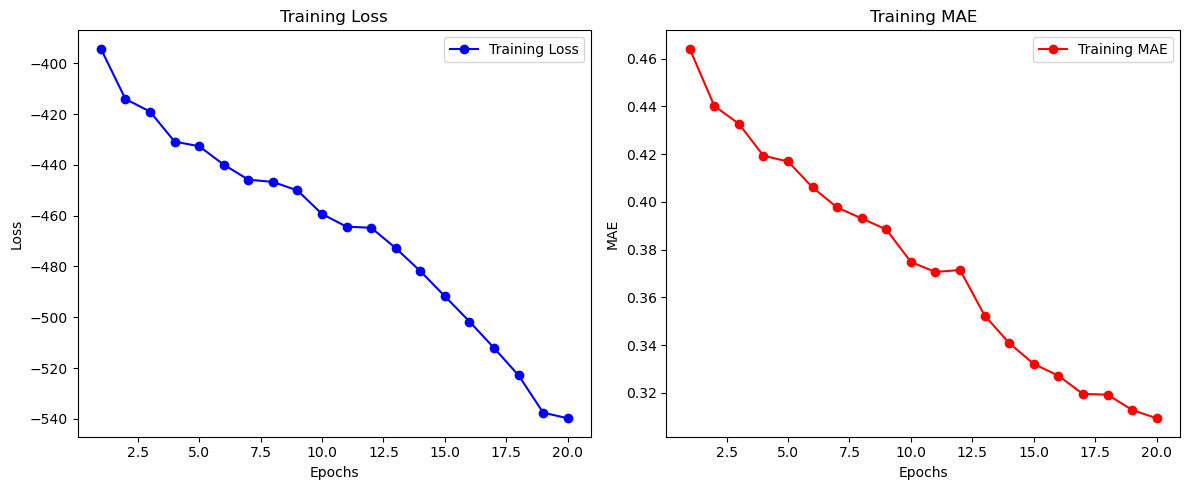

In [ ]:
# ---- Train and Validate the Model for 20 Epochs ----

# Train the model and capture the history
history = umsi_plus_plus.fit(train_data_gen, validation_data=valid_data_gen, epochs=20, steps_per_epoch=len(train_data_gen))
# Plot the learning curve
plot_learning_curve(history)

Epoch 1/20
276/276 [==============================] - 20s 72ms/step - loss: -552.1998 - mae: 0.3029 - val_loss: -398.6552 - val_mae: 0.3049
Epoch 2/20
276/276 [==============================] - 19s 70ms/step - loss: -563.7426 - mae: 0.3039 - val_loss: -406.4741 - val_mae: 0.3040
Epoch 3/20
276/276 [==============================] - 20s 72ms/step - loss: -569.4301 - mae: 0.2998 - val_loss: -404.3225 - val_mae: 0.3014
Epoch 4/20
276/276 [==============================] - 19s 70ms/step - loss: -575.0563 - mae: 0.2998 - val_loss: -395.1504 - val_mae: 0.3068
Epoch 5/20
276/276 [==============================] - 20s 71ms/step - loss: -581.2483 - mae: 0.3004 - val_loss: -411.3526 - val_mae: 0.3216
Epoch 6/20
276/276 [==============================] - 20s 73ms/step - loss: -587.4904 - mae: 0.2970 - val_loss: -394.4715 - val_mae: 0.2979
Epoch 7/20
276/276 [==============================] - 20s 73ms/step - loss: -593.5781 - mae: 0.2987 - val_loss: -397.7894 - val_mae: 0.3031
Epoch 8/20
276/276 [

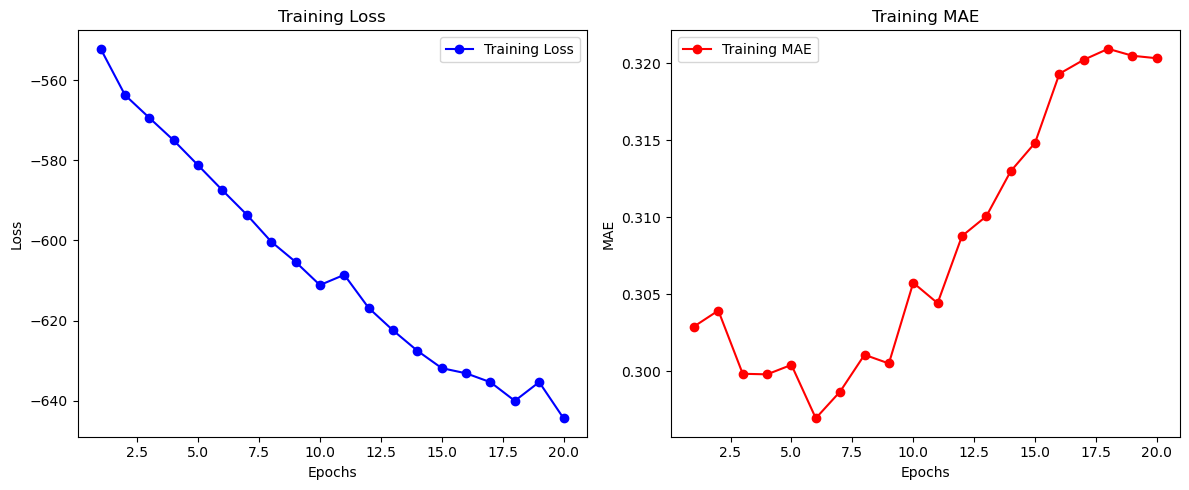

In [ ]:
# ---- Train and Validate the Model for 20 More Epochs (Trained on 40 Epochs Total) ----
history = umsi_plus_plus.fit(train_data_gen, validation_data=valid_data_gen, epochs=20, steps_per_epoch=len(train_data_gen))
# Plot the learning curve
plot_learning_curve(history)

### Evaluate the Model's Performance on Training and Testing Data

1/1 [==============================] - 0s 11ms/step


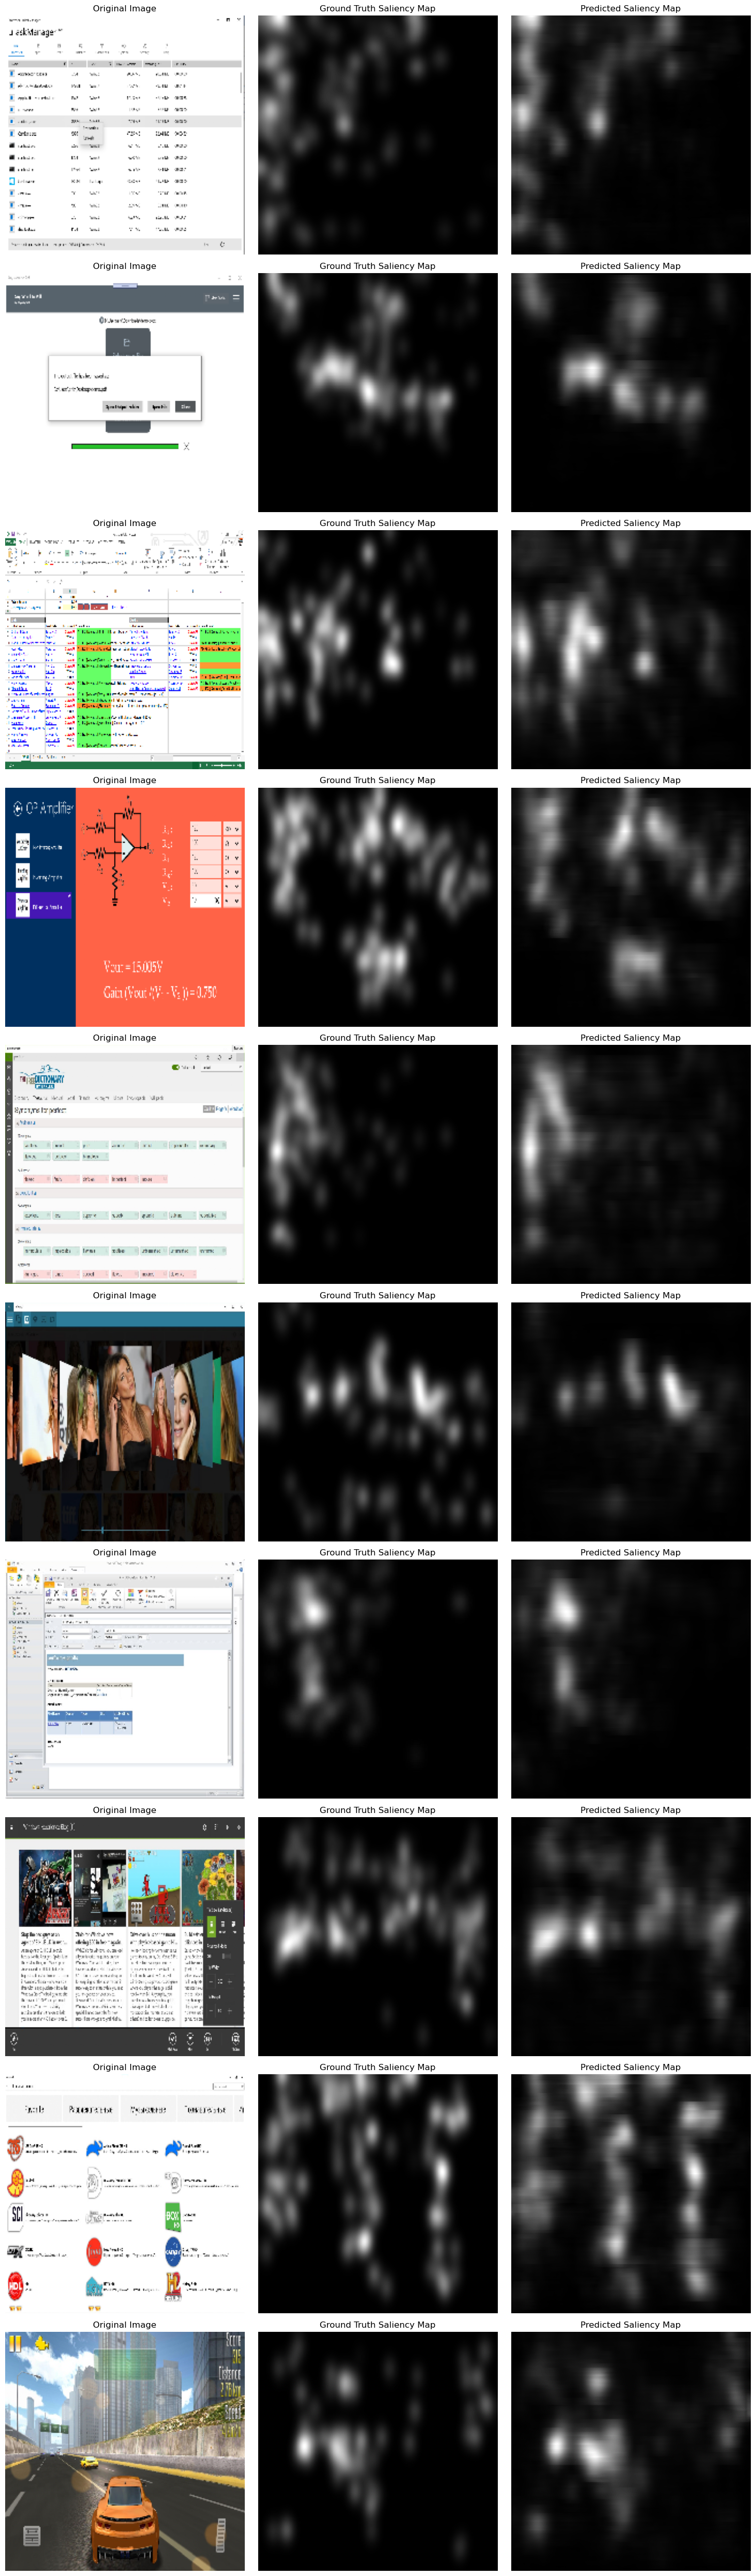

In [43]:
# Visualize the predictions on 10 random training examples
visualize_results(umsi_plus_plus, train_data_gen, num_samples=10)

1/1 [==============================] - 0s 11ms/step


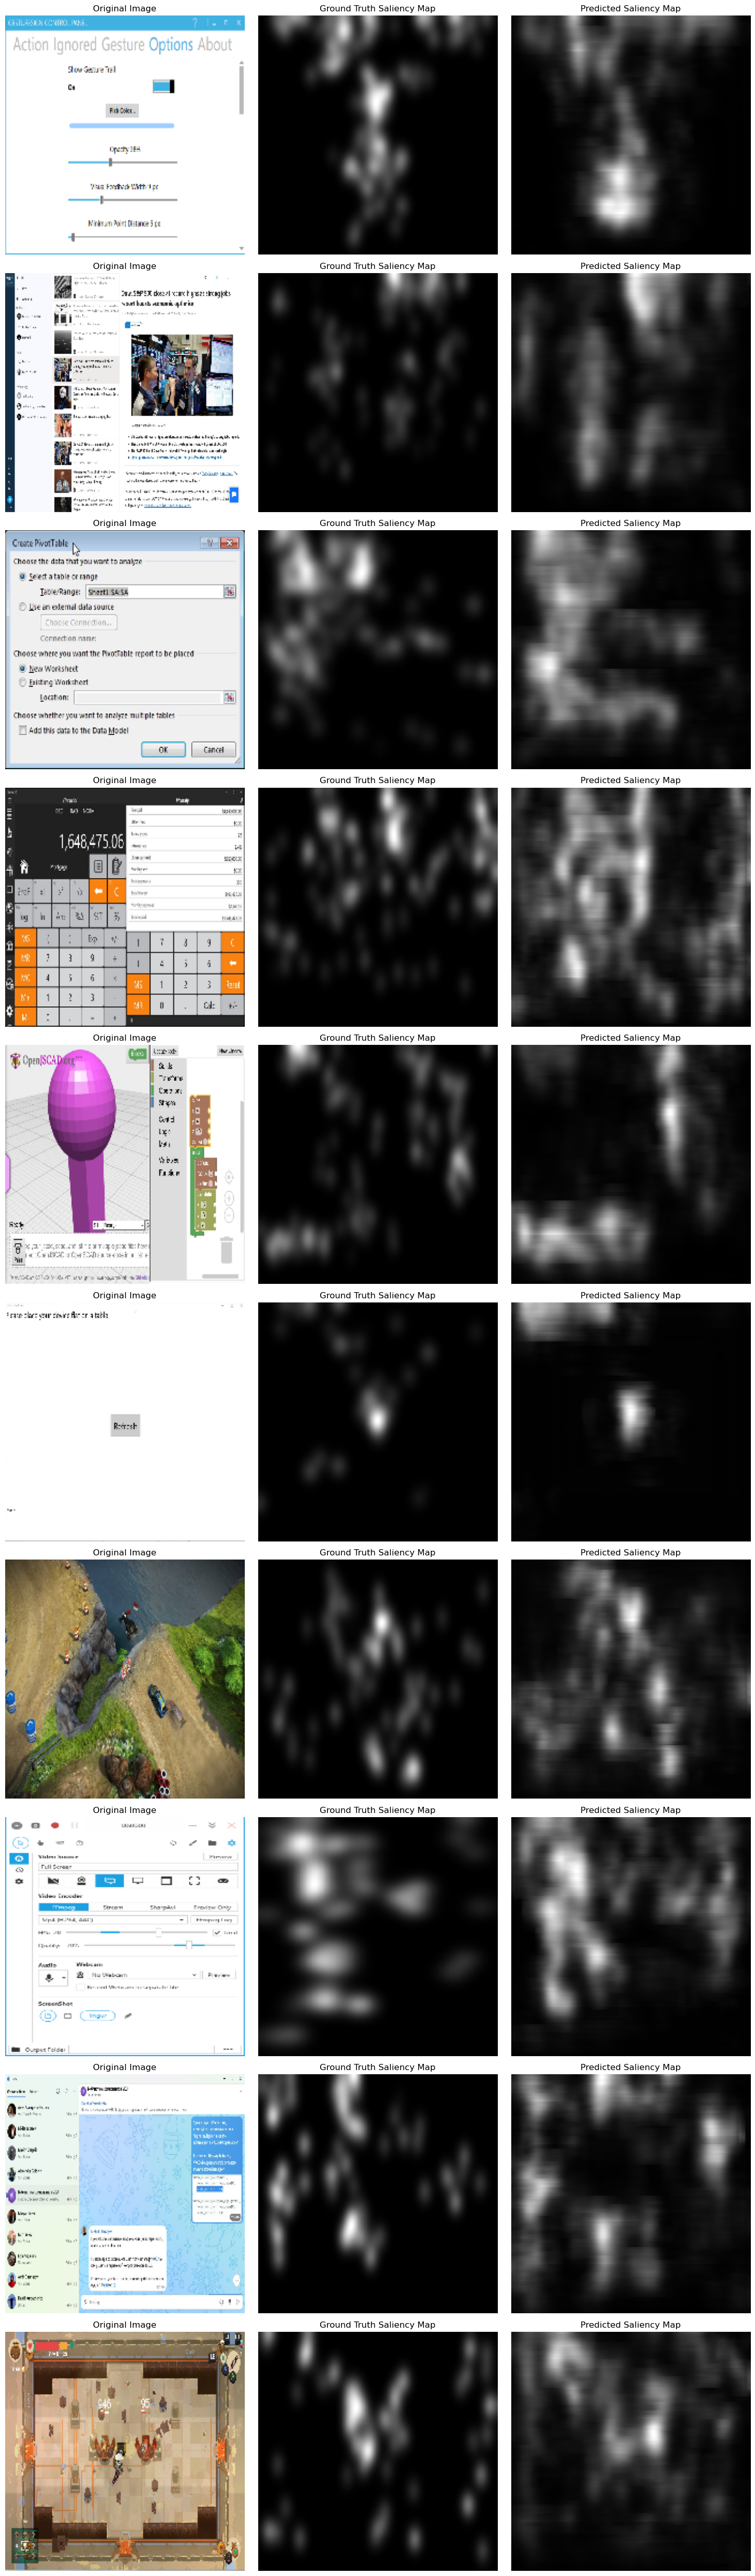

In [44]:
# Performance on test data

# Predict saliency maps
#Y_pred = umsi_plus_plus.predict(test_data_gen) #run this later !!!

# Visualize the predictions on 10 random test examples
visualize_results(umsi_plus_plus, test_data_gen, num_samples=10)